# [Tutorial 2](https://github.com/evolutionaryscale/esm/tree/main/cookbook/tutorials): Embedding with ESM C

In this notebook we will see how to embed a batch of sequences using ESM C, as well as explore its different layers

# Imports

In [ ]:
# Install esm and other dependencies
! pip install esm
! pip install matplotlib

# Set up Forge client for ESM C

Grab a token from [Forge](https://forge.evolutionaryscale.ai/) and add it below. Note that your token is like a password for your account and you should take care to protect it. For this reason it is recommended to frequently create a new token and delete old, unused ones. It is also recommended to paste the token directly into an environment variable or use a utility like `getpass` as shown below so tokens are not accidentally shared or checked into code repositories.

In [2]:
from getpass import getpass

token = getpass("Token from Forge: ")

In [3]:
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

# Set up utilities for embedding sequences

Since we're embedding more than a few sequences, we're going to use a threaded async call to Forge and let Forge take care of batching and parallelization on the backend.

In [4]:
from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

# Requesting hidden states for the 6B model

ESM C 6B's hidden states are really large, so we offer two options:

1) Request mean-pooled hidden states. This allows you to get all layers simultaneously

2) Request one layer at a time. Refer to the model page on https://forge.evolutionaryscale.ai/ to find the number of hidden layers for each model. 

If you for some reason can't assess which layer to choose and have to pick one blindly, the second to last hidden state is a good, safe choice. Often a layer earlier in the model will do a better job at your task. The second best blind guess is often 2/3'rds of the way through the model. The most principled way to make this choice is to write an evaluation for your task and train a classifier at each layer. The performance curve throughout the network will often give a clear indication which part of the network to use.

In [ ]:
# Request mean-pooled hidden states
# MEAN_POOLED_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, return_mean_hidden_states=True)

# Request a single hidden layer at a time
# NUM_ESMC_6B_LAYERS = 80
# ONE_LAYER_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=NUM_ESMC_6B_LAYERS)

# Load dataset

This dataset is taken from Muir, et al. 2024 ["Evolutionary-Scale Enzymology Enables Biochemical Constant Prediction Across a Multi-Peaked Catalytic Landscape"](https://doi.org/10.1101/2024.10.23.619915) which explores a model enzyme called Adenylate Kinase (ADK). Adenylate Kinase appears in many different organisms with different structural classes (referred to as its "lid type"). We'll embed this set of ADK sequences and see if we can recover known structural classes.

In [14]:
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg" -O adk.csv

--2025-10-15 01:22:42--  https://docs.google.com/uc?export=download&id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg
Resolving docs.google.com (docs.google.com)... 142.250.189.174, 2607:f8b0:4005:813::200e
Connecting to docs.google.com (docs.google.com)|142.250.189.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg&export=download [following]
--2025-10-15 01:22:42--  https://drive.usercontent.google.com/download?id=1SpOkL11MJxIgy99dqufvUNJuCiuhxuyg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.191.65, 2607:f8b0:4005:810::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.191.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43132 (42K) [application/octet-stream]
Saving to: ‘adk.csv’

adk.csv             100%[===================>]  42.12K  --.-KB/s    in 0.02s   

2025-

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

adk_path = "adk.csv"
df = pd.read_csv(adk_path)
df = df[["org_name", "sequence", "lid_type", "temperature"]]
df = df[df["lid_type"] != "other"]  # drop one structural class for simplicity

In [16]:
# You may see some error messages due to rate limits on each Forge account,
# but this will retry until the embedding job is complete
# This may take a few minutes to run
outputs = batch_embed(model, df["sequence"].tolist())

In [17]:
import torch

# we'll summarize the embeddings using their mean across the sequence dimension
# which allows us to compare embeddings for sequences of different lengths
all_mean_embeddings = [
    torch.mean(output.hidden_states.float(), dim=-2).squeeze() for output in outputs
]

# now we have a list of tensors of [num_layers, hidden_size]
print("embedding shape [num_layers, hidden_size]:", all_mean_embeddings[0].shape)

embedding shape [num_layers, hidden_size]: torch.Size([31, 960])


# Examine the performance of different layer embeddings

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the [rand index](https://en.wikipedia.org/wiki/Rand_index), a measure of the quality of the clustering.

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3

In [19]:
def plot_embeddings_at_layer(all_mean_embeddings: torch.Tensor, layer_idx: int):
    stacked_mean_embeddings = (
        torch.stack([embedding[layer_idx, :] for embedding in all_mean_embeddings])
        .float()
        .numpy()
    )

    # project all the embeddings to 2D using PCA
    pca = PCA(n_components=2)
    pca.fit(stacked_mean_embeddings)
    projected_mean_embeddings = pca.transform(stacked_mean_embeddings)

    # compute kmeans purity as a measure of how good the clustering is
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_mean_embeddings
    )
    rand_index = adjusted_rand_score(df["lid_type"], kmeans.labels_)

    # plot the clusters
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_mean_embeddings[:, 0],
        y=projected_mean_embeddings[:, 1],
        hue=df["lid_type"],
    )
    plt.title(
        f"PCA of mean embeddings at layer {layer_idx}.\nRand index: {rand_index:.2f}"
    )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()

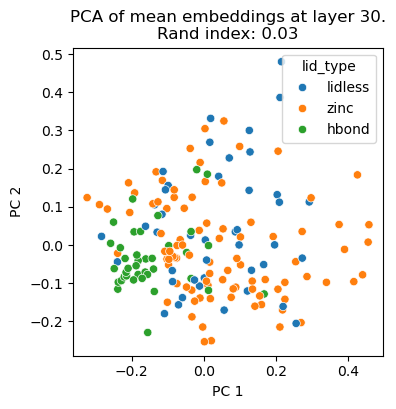

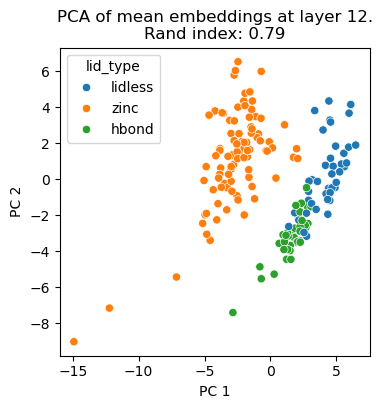

In [20]:
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=30)
plot_embeddings_at_layer(all_mean_embeddings, layer_idx=12)

We see that the top principal components of layer 12 separate structural classes better than that of layer 30. Embed away! And keep in mind that different layers may be better or worse for your particular use-case.